In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd

# Mecab을 colab에 사용하려면 아래 설치가 필요
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy JPype1-py3
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
from konlpy.tag import Okt
from konlpy.tag import Mecab
from konlpy.tag import Kkma

!pip install git+https://github.com/ssut/py-hanspell.git
from hanspell import spell_checker   # 네이버 맞춤법 검사기 
                                     # https://github.com/ssut/py-hanspell


!pip install keybert
from keybert import KeyBERT

import os
import requests
import json
import re
from tqdm import tqdm
import pickle

import gensim

In [6]:
memo_file_path = "/content/drive/MyDrive/KeyBERT/data/memo_hackathon_lesion_info_table.tsv"
stop_words_path = "/content/drive/MyDrive/KeyBERT/data/stopword.txt"
query_keyword_nogari_path = "/content/drive/MyDrive/KeyBERT/data/key_df_nogari.csv"
query_keyword_path = "/content/drive/MyDrive/KeyBERT/data/key_df.csv"

df_memo = pd.read_csv(memo_file_path)

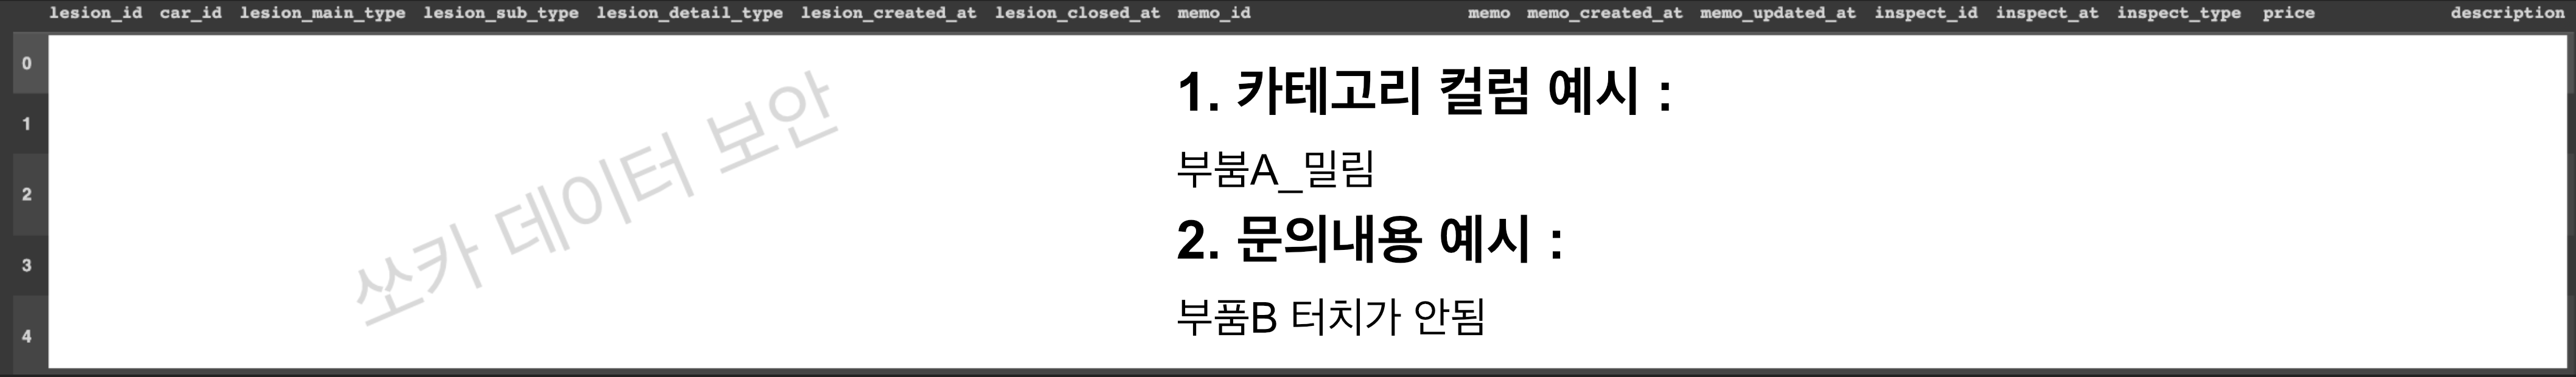

### 문의내용 추출

In [7]:
# 정규표현식으로 문의내용 추출 함수 정의
def regularexp(string):
    regular = re.compile('(?<=문의[내사 ][내용사항 ][용항 ])(.*?)(?=[ㅁ확종긍])')
    string = string.replace(':', ' ').replace('\n', ' ').replace('  ', ' ')

    result1 = regular.search(string).group()
    result2 = re.sub('[^가-힣 ]+', ':', result1).split(':')

    list_query = []
    for sentence in result2:
        if sentence == '' or sentence == ' ': continue
        sentence = sentence.strip()
        list_query.append(sentence)

    return list_query


# 문의내용있는 행 인덱스 추출 
find_words = ['문의내용', 'ㅁ문의내용', '문의 내용', 'ㅁ문의', '문의사항', 'ㅁ문의사항', '문의 사항']

index = []
for idx, row in df_memo.iterrows():
    memo = str(row[9]).replace(":", " ").split()
    for word in find_words:
        if word in memo:
            index.append(idx)


# 문의내용 추출 후 query 컬럼에 넣기
key_df = df_memo.loc[index]
key_df = key_df.reset_index()

key_df['query'] = 0

for idx in range(len(key_df)):
    str1 = regularexp(key_df['memo'][idx])
    key_df['query'][idx] = str1

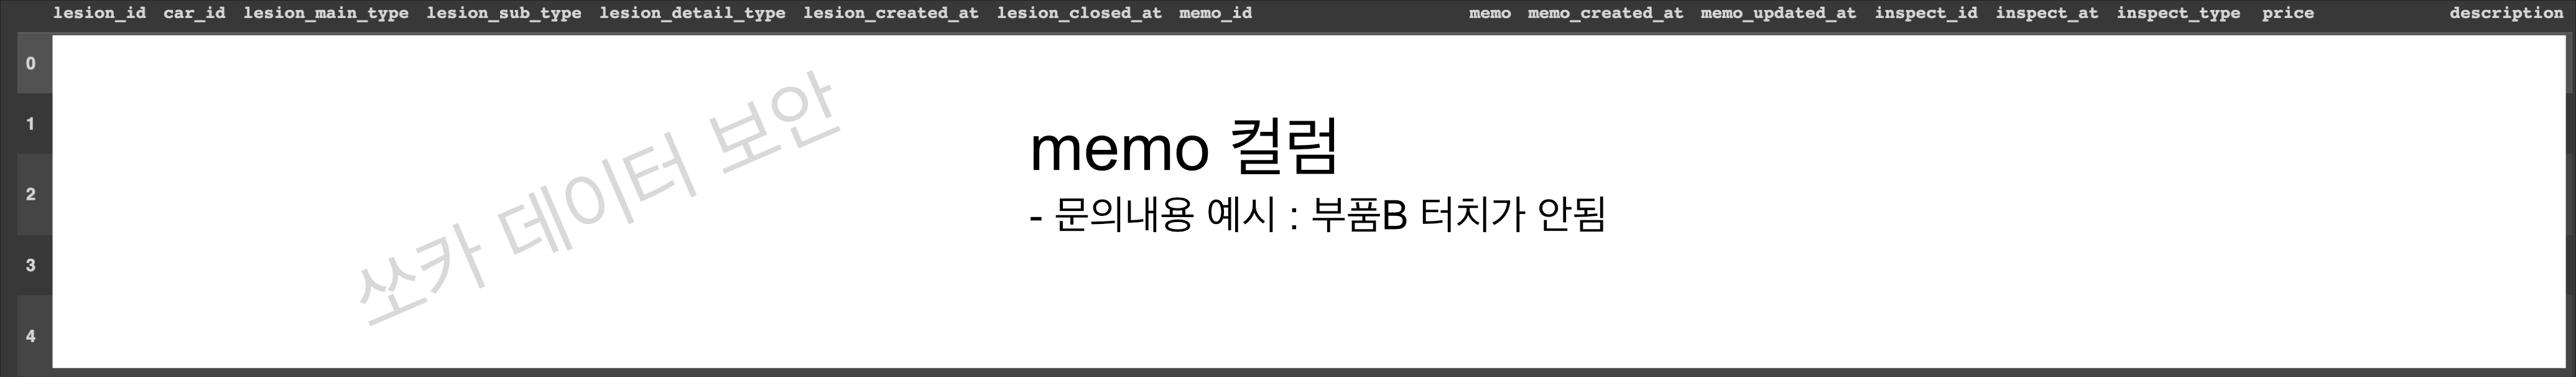

In [ ]:
# 문의내용 개수
print('전체 데이터프레임 개수 :', len(df_memo))
print('문의내용 개수', len(index))

전체 데이터프레임 개수 : 99180
문의내용 개수 13537


### 기본 매핑테이블 생성

In [8]:
# 기본 맵핑테이블 생성 - detail컬럼 사용
def making_mapping_table(df):
    details = df_memo['lesion_detail_type']
    details = details.drop_duplicates()

    arr = []
    mapping = {}

    for detail in details:
        arr.append(detail.replace("/", " ").replace("(", " ").replace(")", "").replace(",", " ").replace("_", " ").replace("  ", " ").split())

    for words in arr:
        if words[0] not in mapping:
            mapping[words[0]] = words[1:]
        else:
            for word in words[1:]:
                if word not in mapping[words[0]]:
                    mapping[words[0]].append(word)
    print(len(mapping))
    
    return mapping

mapping = making_mapping_table(df_memo)

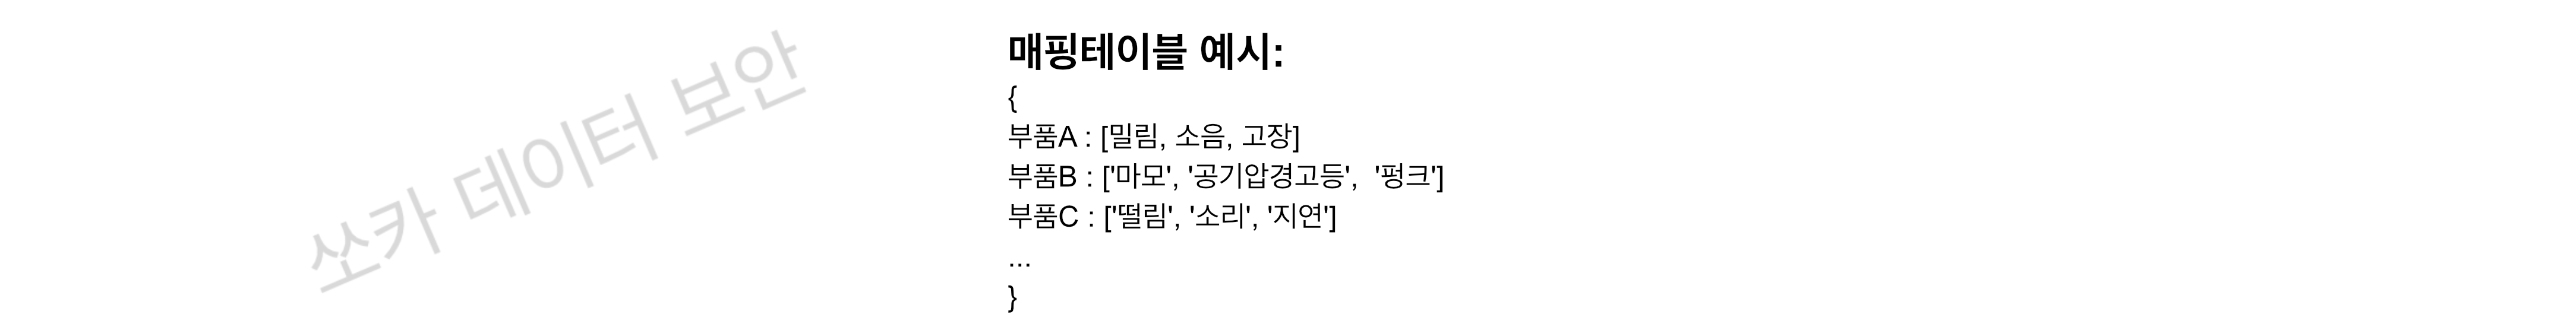

### 불용어

In [ ]:
# 불용어파일을 리스트로 만들기
with open(stop_words_path, "r") as f:
    lines = f.readlines()
    remove_from_stopwords = ['어디\n', '이상\n']                       # 불용어 리스트에서 해당 단어 제거하기. 즉 사용할 단어임
    stop_words = [line.strip() for line in lines if line not in remove_from_stopwords]
    stop_words = list(set(stop_words))
    print('불용어 개수 :', len(stop_words))
    
# 추가할 불용어 
stopword_add = ['고등', '많이', '하심', '걸려서', '나요', '해야', '돼요', '되요', '어요', '다가', '았', '는데', '는지', \
                '인한', '다며', '었', '려는데', '뭔가', '굴러가', '신다고', '온다며', '다고', '으며', '올라가', \
               '진다고', '려던', '인입', '한다고', '할지', '아직', '나와서', '난다고', '걸리', '으면', \
               '라면서', '라면', '나간다고', '는다고', '보인다고', '준다며', '마다', '이나', '으라고', '랬', '층', '건지']

stop_words = stop_words + stopword_add

불용어 개수 : 751


### 한국어 문법 검사기 - 부산대학교

한용님이 추천함 : 국민대학교 문법 검사기 알아보기 - 2021 캡스톤 ..

In [ ]:
def check_spell(text):

    # 1. 텍스트 확인
    text = text.replace('\n', '\r\n')

    # 2. 맞춤법 검사 요청 (requests)
    response = requests.post('http://164.125.7.61/speller/results', data={'text1': text})

    # 3. 응답에서 필요한 내용 추출 (html 파싱)
    data = response.text.split('data = [', 1)[-1].rsplit('];', 1)[0]
    
    # 4. 파이썬 딕셔너리 형식으로 변환
    try:
        data = json.loads(data)

    except:
        print('Spell Check : No need to be changed!!!')
        return text
    
    # 5. 대치어로 치환하기
    for err in data['errInfo']:
        temp = err['candWord'].split('|')
        text = text.replace(err['orgStr'], temp[0])
    
    print('Spell Check :', text)       
    return text

### 형태소 분석기 & KeyBERT 객체 생성
- 형태소 사전을 불러와서 우리에게 필요한 단어 만들도록 하기

In [ ]:
mecab = Mecab()                                       # Mecab 형태소 분석기
kkma = Kkma()                                         # 꼬꼬마 형태소 분석기

kw_model = KeyBERT('distilbert-base-nli-mean-tokens') # BERT 모델

### 함수 정의 : 문의내용 키워드 추출

In [ ]:
# 문의내용 키워드 추출    
# def change(sent):
def keyword_extract(sent):
    output_token = []
    user_keyword = []
                       
    # (1) 맞춤법 검사
    sent = sent.replace('긴출', '긴급출동')          # 검사기가 '긴출' 단어를 '긴축'으로 변경하므로 긴급출동으로 변경해놓기
    spelled_sent = check_spell(sent)              # 부산대학교 맞춤법 검사기 
          

    # (2) 형태소 분석 - 명사 추출
    tokenized_mecab = mecab.nouns(spelled_sent)   
    tokenized_kkma = kkma.nouns(spelled_sent)
    tokenized_nouns = list(set(tokenized_mecab + tokenized_kkma))
    
    # (3) 불용어 제거  # 한용님께서 더 좋은 코드 주신다고 하셨음
    for token in tokenized_nouns: 
        if token not in stop_words:
            output_token.append(token)
    sent = " ".join(output_token)
    
    # (4) 키워드 추출
    keywords = kw_model.extract_keywords(sent)
    if len(keywords) == 0:                         # 키워드가 없다면 그냥 문장 추출
        return sent
    else:
        for i, _ in keywords:                      # 키워드가 있다면 키워드 모두 추출 
            user_keyword.append(i)
        return user_keyword

### 함수 정의 : 문의내용 매핑테이블 생성

In [ ]:
def query_keyword(df):
    
    # (1) 문의내용 중복 제거
    query_list = list(set([row for rows in key_df['query'] for row in rows if len(row) > 1]))

    # (2) 문의내용 키워드 추출후 매핑테이블 만들기
    mapping = {}
    temp = []
    for idx, row in enumerate(tqdm(query_list)):
        keywords = keyword_extract(row)                 # 키워드 추출 함수 호출
        if len(keywords) == 0:                          # 키워드가 없으면 넘기기
            temp.append(idx)
            print(row, idx)
            continue
        if keywords[0] not in mapping:                  # 확률이 가장 높은 키워드가 없으면 mapping 딕셔너리에 그 외의 키워드들을 넣기
            mapping[keywords[0]] = keywords[1:]
        else:                                           # 확률이 가장 높은 키워드가 있으면 mapping 딕셔너리에 그 외의 키워드들을 추가하기
            mapping[keywords[0]] = mapping[keywords[0]] + keywords[1:]

        # mapping 중간 저장
        if idx % 100 == 0:
            with open(f'mapping_table_{idx}.pkl','wb') as f:
                pickle.dump(mapping, f)
                print('저장 완료!')
                
    # 매핑테이블 value 중복값 없애기
    for key, val in mapping.items():
        mapping[key] = list(set(val))
        
    return mapping, temp

In [ ]:
# 문의내용 맵핑테이블 만들기
## 너무 오래걸려서 취소하고 아래 저장파일 불러와라
mapping_table, temp = query_keyword(key_df)
mapping_table

### 저장 및 불러오기 : 매핑테이블

In [ ]:
# with open('data/mapping_table_unique_backup_copy1','wb') as f:
#     pickle.dump(mapping_table, f)
#     print('저장 완료!')

with open('data/mapping_table_unique_backup_copy1.pkl', 'rb') as f:
    mapping_table = pickle.load(f)
    print(len(mapping_table))
    print('로딩 완료!')

1008
로딩 완료!


### 문의사항 키워드를 기본매핑테이블에 추가

In [1]:
def add_mapping(basic, query): # basic : 기존 맵핑테이블, query_key : 문의사항 키워드 매핑테이블
    
    # 기존 매핑테이블에 문의사항 매핑테이블 합치기
    for key, val in query.items():
        if key not in basic:        # 문의내용 키워드 맵핑테이블의 Key가 기본매핑테이블에 없으면 새로운 Key로 생성해서 value를 채워넣기
            basic[key] = val
        else:                       # 문의내용 키워드 맵핑테이블의 Key가 기본매핑테이블에 있으면 value를 추가하기
            basic[key] = basic[key] + val           
    


    for k, v in basic.items():
        basic[k].append(k)          # 각 Key마다 value에 자기 자신(Key) 추가. 목적은 한 번 더 카운트되도록 가중치 부여
        basic[k] = list(set(v))     # 매핑테이블 value 중복값 없애기
        
    return basic

mapping_table_total = add_mapping(mapping.copy(), mapping_table) # mapping : 기본 맵핑테이블, mapping_table: 문의내용 키워드 추출한 매핑테이블

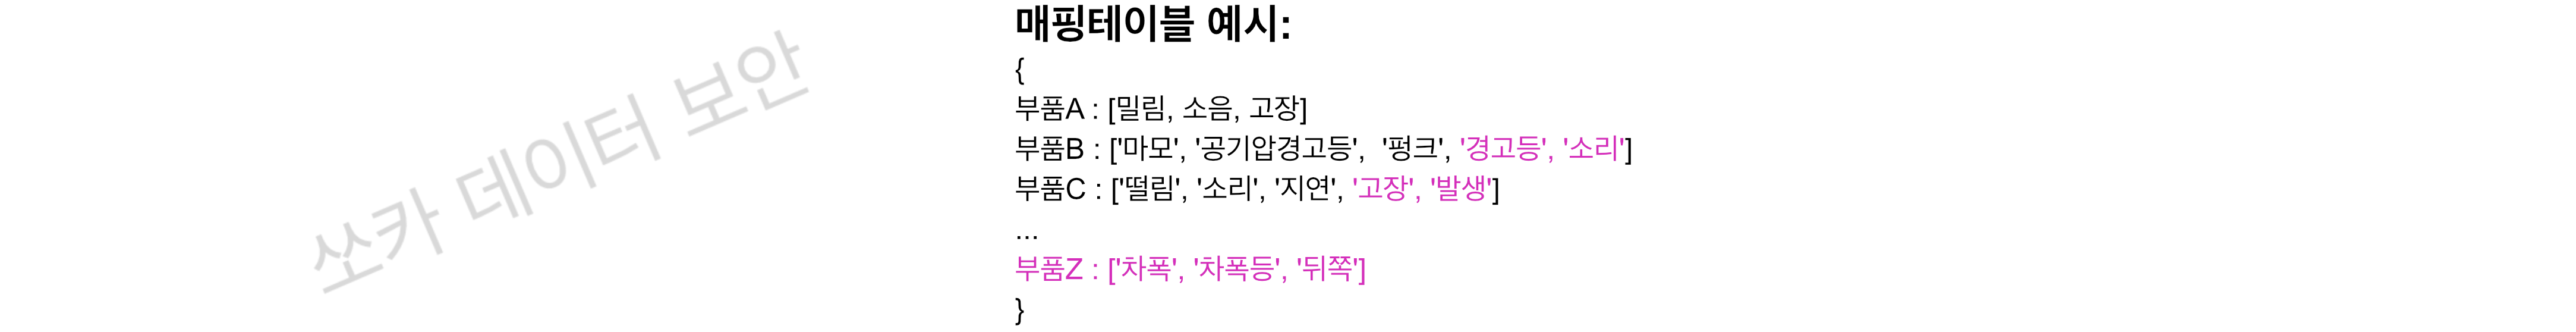

In [ ]:
# 키워드 추가한 mapping_table 저장 및 불러오기
# with open('mapping_table_total.pkl','wb') as f:
#     pickle.dump(mapping_table_total, f)

with open('mapping_table_total.pkl', 'rb') as f:
    mapping_table_total = pickle.load(f)

In [ ]:
print(len(mapping))  # 기본 매핑테이블
print(len(mapping_table)) # 문의내용 키워드 매핑테이블
print(len(mapping_table_total)) # 위 두 개 합친거

51
1008
1025


In [ ]:
# 매핑테이블에 필요한 단어들 추가해놓기
mapping_table_total['차량위치'] = ['쏘카존', '어디', '차량', '쏘', '카', '존', '찾아봐도', '찾을수가' '아무리']
mapping_table_total['소음'] = ['소음', '이상한', '소리', '주행', '내부', '이상', '난다', '납니다']
mapping_table_total['시동'].append('출발')
mapping_table_total['블랙박스'].append('화면')
mapping_table_total['내비게이션'].extend(['네비', '너비'])

# 쏘카존 Key에 value 추가
socazon = ['쏘카존', '어디', '차량', '쏘', '카', '존', '찾아봐도', '찾을수가', '아무리']
for word in socazon:
    if word not in mapping_table_total['쏘카존']:
        mapping_table_total['쏘카존'].append(word)

# (고객 문의 키워드가) 매핑테이블 value에 존재하는 경우와 존재 안하는 경우


## STEP 1 - (고객 문의) 키워드 추출

In [ ]:
# user_sent = '안녕하세요!!! 지금 네비가 어디 있는지 모르겠어요 도와주세요'                  # ok 
# user_sent = '제가 쏘카존에 왔는데 아무리 찾아봐도 빌린 차량이 어디 있는지 모르겠어요..'       # ok
# user_sent = '브레이크액이 없는거 같습니다.'                                         # ok
# user_sent = '후방카메라가 안되요'                                                 # ok
user_sent = '출발하려고 시동을 걸었는데 시동이 안켜져요. 어떻게 해야할지 알려주세요'            # ok
# user_sent = '주행중에 이상한 소음이 납니다. 어떻게 해야할지 알려주세요'                    # bad
# user_sent = '엔진에서 이상한 소음이 납니다. 어떻게 해야할지 알려주세요'                    # ok

# user_sent = '이상한 소리가 나요. 어떻게 해야할지 알려주세요'                            # ok
# user_sent = '블랙박스 화면이 안들어와요'                                            # ok
# user_sent = "안녕하세ㅋㅋㅋㅋ 지금 네비게이션 가 잘 안되네요"                            # ok
# user_sent = "사고가 났습니다. 어떻게 해야 되나요?"                                    # ok
# user_sent = "트렁크 문이 안닫힙니다"                                               # ok
# user_sent = "구매권을 변경하고 싶습니다. 어떻게 해야 되나요?"                            # bad


keywords = keyword_extract(user_sent)
keywords

['출발', '시동']

## STEP 2 - 함수 정의

### (1) 고객 문의에서 추출된 키워드가 매핑테이블 Value에 존재하는 경우
value의 값을 카운팅 합산 중 가장 높은 값의 키를 반환

: 최소 두 개 단어 추출 -> 매핑테이블 values에서 단어 횟수 세기 -> 벨류들의 합산값 비교 -> 벨류 상위 합산값의 키를 반환

In [ ]:
def existing(sorted_dic, user_sent):   
    print('키워드 존재하는 경우 수행')
    print('-'*115)                                              
    print('Counted Value Dictionary :\n', sorted_dic)       

    #(1) Counted Value Dictionary에서 최대 value인 key들 추출
    output_list = []
    for k, v in sorted_dic.items():
        if v == max(sorted_dic.values()):   
            output_list.append(k)

    print('-'*115)
    print('고객문의 원문 :', user_sent)
    print('Max value의 key 리스트 :', output_list)
   
    # (2) 맞춤법 검사
    user_sent = check_spell(user_sent)        # 부산대학교 맞춤법 검사기 


    # (3) 고객 문의 원문에서 명사 추출 - 형태소 분석기
    re_extracted_mecab_nouns = mecab.nouns(user_sent)
    re_extracted_kkma = kkma.nouns(user_sent)
    re_extracted_total = list(set(re_extracted_mecab_nouns + re_extracted_kkma)) # mecab과 kkma가 출력하는 명사 결과가 다르므로 두 개의 앙상블로 진행함
    print('문의내용 중 명사 추출 :', re_extracted_total)
    
    # (4) 불용어 제거
    after_token = []
    for token in re_extracted_total: 
        if token not in stop_words:
            after_token.append(token)

    
    # (5) 문의내용 명사와 최대 value인 key 비교 후 해당 인덱스 추출
    ## 최대 value인 키들 중에서 다시 한 번 고객의 문의 내용과 비교하여 키워드 추출
    indexes = [0] * len(output_list)
    for idx, output in enumerate(output_list):
        for extracted in after_token:
            if extracted in output:  # in을 사용한 이유 : 예를 들어, 브레이크가 브레이크액에 포함되는지 확인. == 사용하면 관련성이 있음에도 한 글자라도 다르면 False로 판단하므로
                indexes[idx] += 1
    i = indexes.index(max(indexes))
    
    return (output_list[i], output_list)

### (2) 존재하지 않는 경우 - FastText
: mapping table의 key들의 벡터와 고객 문의 벡터와의 유사도


FastText는 모르는 단어도 내부단어(Subword)를 통해 유사도를 구할 수 있는 장점이 있음  
https://wikidocs.net/22883  
- 매핑테이블 value값을 학습 -> 고객의 키워드(학습되지 않은)를 넣어 유사한 단어 추출 -> 모델에 넣어 카테고리 키워드 추출


In [ ]:
# 매핑테이블 value값을 gensim 형태 만듦
w2v_train = []
for val in mapping_table_total.values():
    w2v_train.append(val)
    
# 학습
model = gensim.models.FastText(vector_size=300, window=10, min_count=1)  # instantiate
model.build_vocab(w2v_train)
model.train(corpus_iterable=w2v_train, total_examples=len(w2v_train), epochs=100)  # train

(662602, 798700)

In [ ]:
# 유사도 확인
# model.wv.most_similar('결제 취소 환불', topn=10)
# model.wv.most_similar('취소 환불 결제', topn=10)
# model.wv.most_similar('환불 결제 취소', topn=10)
# model.wv.most_similar('구매권 변경 구매', topn=10)
# model.wv.most_similar('변경 구매 구매권', topn=10)
# model.wv.most_similar('구매 구매권 변경', topn=10)
model.wv.most_similar('블랙박스 박스 블랙 화면', topn=10)

[('블랙', 0.9707136750221252),
 ('영상', 0.9481210708618164),
 ('경찰', 0.9460887312889099),
 ('블랙박스', 0.9331735372543335),
 ('모바일네트워크', 0.9266461730003357),
 ('차량블랙박스', 0.9115644097328186),
 ('롯데', 0.9101399779319763),
 ('참고하', 0.9072051644325256),
 ('미작동문', 0.9055360555648804),
 ('분사', 0.9054846167564392)]

## STEP 3 - (추출된 키워드로) 매핑테이블 카테고리 선택

In [ ]:
def count_values_keywords(keywords, user_sent, mapping_table_total):
    # (1) 카운트 딕셔너리 만듦 후 매핑테이블 키들에 대해 0으로 초기화
    count_dict = {}
    for k in mapping_table_total.keys():
        count_dict[k] = 0

    # (2) 매핑테이블 각 Key의 value에 추출된 키워드가 몇 개 존재하는지 개수 세기
    for keyword in keywords:
        for key in mapping_table_total.keys():
            count = 0
            for value in mapping_table_total[key]:
                if keyword == value:
                    count += 1

            count_dict[key] = count_dict[key] + count

        # (3) 추출된 키워드가 카테고리 이름과 같다면 가중치로 1 추가해줌
        if keyword in count_dict.keys():
            count_dict[keyword] = count_dict[keyword] + 1
    
    # (4) 카운트 딕셔너리 내림차순으로 정렬       
    sorted_dic = dict(sorted(count_dict.items(), key=lambda x: x[1], reverse=True))

    # (5) 카테고리 선택
    if max(sorted_dic.values()) == 0:                            # 어떤 키워드도 매핑테이블에 존재하지 않는 경우
        print('최대값이 0 -> 키워드 존재하지 않는 경우를 수행')
        print('FastText 함수 호출')
        final_key = 'FastText 함수 결과값'
        return (final_key, _ )
    else:
        final_key, output_list = existing(sorted_dic, user_sent) 
        return (final_key, output_list)

final_key, output_list = count_values_keywords(keywords, user_sent, mapping_table_total)
print(final_key)

키워드 존재하는 경우 수행
-------------------------------------------------------------------------------------------------------------------
Counted Value Dictionary :
 {'주행': 3, '문의': 3, '엔진': 3, '발생': 3, '지속': 3, '브레이크': 2, '타이어': 2, '경고등': 2, '내비게이션': 2, '핸들': 2, '창문': 2, '에어컨': 2, '와이파이': 2, '운전석': 2, '소음': 2, '반납': 2, '운행': 2, '엔진룸': 2, '소음문의': 2, '이상': 2, '엔진소음': 2, '속도': 2, '이상하다': 2, '액셀': 2, '라이트': 1, '시동': 1, '후방카메라': 1, '오디오': 1, '주유구': 1, '단말기': 1, '사이드미러': 1, '사이드브레이크': 1, '트렁크': 1, '도어': 1, '히터': 1, '룸미러': 1, '공기압': 1, '하부': 1, '긴급출동': 1, '쏘카존': 1, '상태': 1, '전조등': 1, '급발진': 1, '연기': 1, '작동': 1, '심각': 1, '아르피엠': 1, '조수석': 1, '문제': 1, '주차': 1, '안내': 1, '변경': 1, '목적지': 1, '고속도': 1, '진동음': 1, '공업사': 1, '제동': 1, '점검요청': 1, '연락': 1, '말씀': 1, '원전': 1, '조작': 1, '주장': 1, '과열': 1, '상담': 1, '점등': 1, '요청': 1, '주유소': 1, '액셀러레이터': 1, '손님': 1, '등둥': 1, '코너링': 1, '기어봉도': 1, '엔진오일': 1, '엔진소리': 1, '대차해드림': 1, '노란색': 1, '사용': 1, '주유가': 1, '유입': 1, '플라스틱': 1, '하부소음': 1, '배차': 1, '발판': 1, '경고': 1, '우는소

문의내용 중 명사 추출 : ['소음', '엔진', '이상']


'엔진'